In [ ]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/NASSTex_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle
import pandas as pd
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
from collections import OrderedDict
import os
import sys
import scipy
import cosima_cookbook as cc
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    
import matplotlib.path as mpath 
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cartopy.feature as cft
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Loading in the data

In [ ]:
%%time
#session = cc.database.create_session('/home/561/mv7494/NA_SST_extremes_scripts/NA_SST_extremes.db')
directory_list = ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/',
                  '/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle4_jra55v150_extension/']

In [ ]:
%%time
# ---------------------------------------------------------------------------------- #
depth         = [         0] # select sea surface
clim_range    = [264, (264+30*12)] # to select the clim. period 1980 - 2010
# NA_lat        = [1560, 2346] # 30°N - 75°N
# NA_lon        = [2049, 2951] # 75°W - 15°E
for f in range(3):
    if f == 0:
        region = [40, 60, -60,   0]; suffix = 'NA_zonal_band'
    if f == 1:
        region = [40, 60, -60, -40]; suffix = 'NA_hotspot'
    if f == 2:
        region = [10, 30, -40, -20]; suffix = 'NA_hotspot_SE'
    # ---------------------------------------------------------------------------------- #
    # using 1980-2010 as climatology (1980 is after the rapid adjustment from the previous cycle)
    sst_clim = xr.open_mfdataset(directory_list[0]+'output*/ocean/ocean-3d-temp-1-monthly-mean*.nc').temp.sel(
        yt_ocean=slice(region[0],region[1])).sel(xt_ocean=slice(region[2],region[3]))[:,0,:,:].mean(['yt_ocean', 'xt_ocean'])
    sst = xr.open_mfdataset(directory_list[1]+'output*/ocean/ocean-3d-temp-1-monthly-mean*.nc').temp.sel(yt_ocean=slice(region[0],region[1])).sel(xt_ocean=slice(region[2],region[3]))[:,0,:,:].mean(['yt_ocean', 'xt_ocean'])
    
    # remove monthly mean to calculate anomalies
    sst_anom = (sst.groupby('time.month') - sst_clim.groupby('time.month').mean('time')).load()
    if f == 0: NA_zonal_band = sst_anom
    if f == 1: NA_hotspot    = sst_anom
    if f == 2: NA_hotspot_SE = sst_anom
    print(suffix + ' done')
# Wall time: 1min 23s

### SST pattern for inset

In [ ]:
%%time
month         = [-3] # [-3] = June 2023
depth         = [         0] # select sea surface
clim_range    = [ 264, (264+30*12)] # to select the clim. period 1980 - 2010
NA_lat        = [ 500, 2346] # 30°N - 75°N
NA_lon        = [2049, 2951] # 75°W - 15°E

# using 1980-2010 as climatology (1980 is after the rapid adjustment from the previous cycle)
sst_clim = xr.open_mfdataset(directory_list[0]+'output*/ocean/ocean-3d-temp-1-monthly-mean*.nc'
                       ).temp[clim_range[0]:clim_range[1],depth[0], NA_lat[0]:NA_lat[1],NA_lon[0]:NA_lon[1]]

sst = xr.open_mfdataset(directory_list[1]+'output*/ocean/ocean-3d-temp*.nc'
                       ).temp[:,depth[0], NA_lat[0]:NA_lat[1],NA_lon[0]:NA_lon[1]]
# remove monthly mean to calculate anomalies
sst_anom = (sst.groupby('time.month') - sst_clim.groupby('time.month').mean('time'))[month[0],:,:].load()
# Wall time: 1min 58s

### Plotting routine

In [ ]:
%%time
fig = plt.figure(figsize=(8,6),tight_layout=True,facecolor='w',edgecolor='k')
ax1 = plt.subplot(1,1,1)
ax1.text(-.15, 1.05, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # panel label

# ----------------------------------------------------------------------------------------------------------------- #
NA_hotspot.plot(c=rotblau[3], label = 'NA_hotspot')
NA_zonal_band.plot(c=rotblau[16], label = 'NA_zonal_band')
NA_hotspot_SE.plot(c=rotblau[20], label = 'NA_hotspot_SE')
plt.scatter(NA_hotspot[54].time, NA_hotspot.max(), s=200, marker = '*', color=rotblau[3], label='July 2023')
ax1.hlines(NA_hotspot.max(),NA_hotspot[0].time, NA_hotspot[54].time, color=rotblau[3], lw=.5) # hline(y, xmin, xmax)
# ----------------------------------------------------------------------------------------------------------------- #

plt.title('North Atlantic sea surface temperature anomalies', fontsize=16)
plt.ylabel('(°C)', fontsize=16); plt.xlabel('Year', fontsize=16);
plt.axhline(0, c='grey', lw=.5)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.xlim([NA_hotspot[0].time, NA_hotspot[-1].time])

# small geographic inset
# ----------------------------------------------------------------------------------------------------------------- #
ax1 = fig.add_axes((.5,.6,.2,.2),projection = ccrs.PlateCarree())
ax1.text(-.2, 1, string.ascii_lowercase[1], transform=ax1.transAxes, size=16, weight='bold') # panel label
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='grey', facecolor='gray', linewidth=0.5)
ax1.add_feature(land_50m, color=[0.81, 0.81, 0.81]); ax1.coastlines(resolution='50m')
ax1.set_extent([-75, 15, 0, 75], crs=ccrs.PlateCarree()) # extent of plot

p1  = sst_anom.plot.contourf(ax=ax1,levels=np.linspace(-4,4,21),cmap='RdBu_r',
                         extend='both',add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('July 2023', fontsize=16)

# add rectangles
region = [40, 60, -60,   0]
ax1.gridlines(color=rotblau[3], linewidth=2, xlocs=[region[2], region[3]], ylocs= [region[0], region[1]], 
             xlim=[region[2], region[3]], ylim=[region[0], region[1]]) # rectangle
region = [40, 60, -60, -40]
ax1.gridlines(color=rotblau[16], linewidth=2, xlocs=[region[2], region[3]], ylocs= [region[0], region[1]], 
             xlim=[region[2], region[3]], ylim=[region[0], region[1]]) # rectangle
region = [10, 30, -40, -20]
ax1.gridlines(color=rotblau[20], linewidth=2, xlocs=[region[2], region[3]], ylocs= [region[0], region[1]], 
             xlim=[region[2], region[3]], ylim=[region[0], region[1]]) # rectangle
# --- saving as 300 dpi .PNG image in specified folder ----------------------------------------------- #
filename = 'time_series_SST_evolution'
plt.savefig(save + filename, dpi=300, facecolor='w', edgecolor='w', orientation='landscape',           #
            format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)        #
# --- end of script ---------------------------------------------------------------------------------- #
# Wall time: 2.21 s


# ACHTUNG! Etwas stimmt nicht mit der Zeitreihe und der Karte überein...Zeitreihe peaked in July und spatial Map im Juni!!!!
## Fix this when I revisit the project

### Create twitter-like time series showing annual North Atlantic (0°N-60°N) SST time series for 1958-2023
- Inspiration: https://twitter.com/LeonSimons8/status/1719730744279384552

In [ ]:
%%time
# ---------------------------------------------------------------------------------- #
depth         = [               0] # select sea surface
clim_range    = [264, (264+30*12)] # to select the clim. period 1980 - 2010
clim_range2   = [8035, 19358] # to select the clim. period 1980 - 2010 in the daily data
# NA_lat        = [1560, 2346] # 30°N - 75°N
# NA_lon        = [2049, 2951] # 75°W - 15°E
for f in range(1):
    if f == 0:
        region = [50, 60, -60,   0]; suffix = 'NA_0_60N'
    # ---------------------------------------------------------------------------------- #
    # using 1980-2010 as climatology (1980 is after the rapid adjustment from the previous cycle)
    # monthly data
    # sst_clim = xr.open_mfdataset(directory_list[0]+'output*/ocean/ocean-3d-temp-1-monthly-mean*.nc').temp.sel(
    #     yt_ocean=slice(region[0],region[1])).sel(xt_ocean=slice(region[2],region[3]))[:,0,:,:].mean(['yt_ocean', 'xt_ocean'])
    
    # using daily data instead
    sst_clim = xr.open_mfdataset(directory_list[0]+'output*/ocean/ocean-2d-surface_pot_temp-1-daily-mean*.nc').surface_pot_temp.sel(
        yt_ocean=slice(region[0],region[1])).sel(xt_ocean=slice(region[2],region[3])).mean(['yt_ocean', 'xt_ocean'])[clim_range2[0]:clim_range2[1]]
    sst = xr.open_mfdataset(directory_list[0]+'output*/ocean/ocean-2d-surface_pot_temp-1-daily-mean*.nc').surface_pot_temp.sel(
        yt_ocean=slice(region[0],region[1])).sel(xt_ocean=slice(region[2],region[3])).mean(['yt_ocean', 'xt_ocean'])
    sst_extension = xr.open_mfdataset(directory_list[1]+'output*/ocean/ocean-2d-surface_pot_temp-1-daily-mean-ym_*.nc').surface_pot_temp.sel(
        yt_ocean=slice(region[0],region[1])).sel(xt_ocean=slice(region[2],region[3])).mean(['yt_ocean', 'xt_ocean'])
# Wall time: 31.7 s

In [ ]:
%%time
sst_anom = sst.groupby('time.month') - sst_clim.groupby('time.month').mean('time'); sst_anom.plot() # preliminary plotting

In [ ]:
sst_anom[0:365].plot()

In [ ]:
sst_anom2 = (sst_extension - sst_clim.groupby('time.month').mean('time')).load(); sst_anom2.plot() # preliminary plotting
# Wall time: 24.5 s

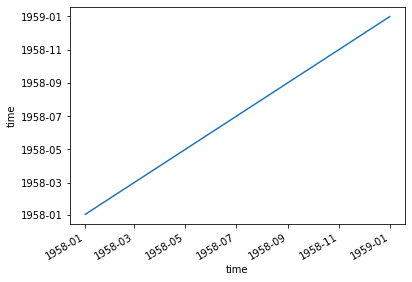

In [170]:
sst_anom[0:365].time.plot()

Text(0.5, 1.0, 'North Atlantic (0°-60°N) monthly SST anomalies\n(1980-2010 climatology)')

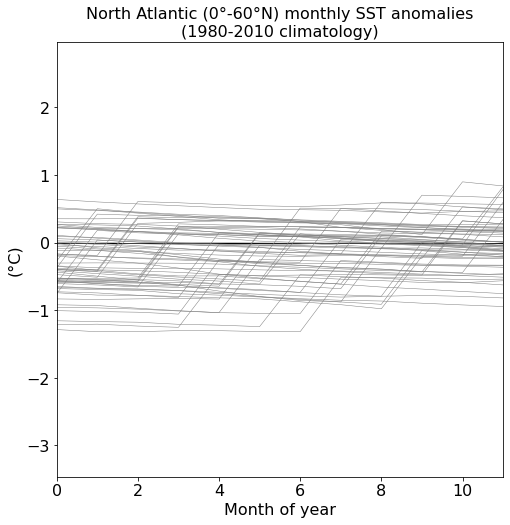

In [166]:
plt.figure(figsize=(8,8))
def chunker(seq, size): # function that lets me loop through a time series in chunks of x values 
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
plt.axhline(0, c='k', lw=1)
for group in chunker(sst_anom.values, 365): # select chunks of 12
    plt.plot(group, c = 'grey', lw=.5)

# for group in chunker(sst_anom2.values, 12): # select chunks of 12
#     plt.plot(group, c = 'orange', lw=1.5)    
    
    
    plt.xlim([0,11]); plt.ylabel('(°C)', fontsize=16); plt.xlabel('Month of year', fontsize=16)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
# ------------------------------------------------------------------------ #
# plt.plot(sst_anom2[0:12], c = 'grey', lw=.5) # the extension years -> 2019
# plt.plot(sst_anom2[12:24], c = 'grey', lw=.5) # 2020
# plt.plot(sst_anom2[24:36], c = 'grey', lw=.5) # 2021
# plt.plot(sst_anom2[36:48], c = 'grey', lw=.5) # 2022
# plt.plot(sst_anom2[48:], c = rotblau[3], lw=2) # 2023
# ------------------------------------------------------------------------ #
plt.title('North Atlantic (0°-60°N) monthly SST anomalies\n(1980-2010 climatology)', fontsize=16)